In [43]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split , GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import seaborn as sns

np.random.seed(42)

In [25]:
df=pd.read_csv('galaxyquasar.csv')

#u-g, g-r, r-i, i-z

df['ug']=df['u']-df['g'] #0
df['gr']=df['g']-df['r'] #1
df['ri']=df['r']-df['i'] #2
df['iz']=df['i']-df['z'] #3

label_map = {'GALAXY': 0, 'QSO': 1}
df['class_label'] = df['class'].map(label_map).to_numpy()

galaxy = df[df['class_label'] == 0]
qso = df[df['class_label'] == 1]

features = ['ug', 'gr', 'ri', 'iz']

In [26]:
galaxy.shape

(42866, 13)

In [27]:
qso.shape

(7134, 13)

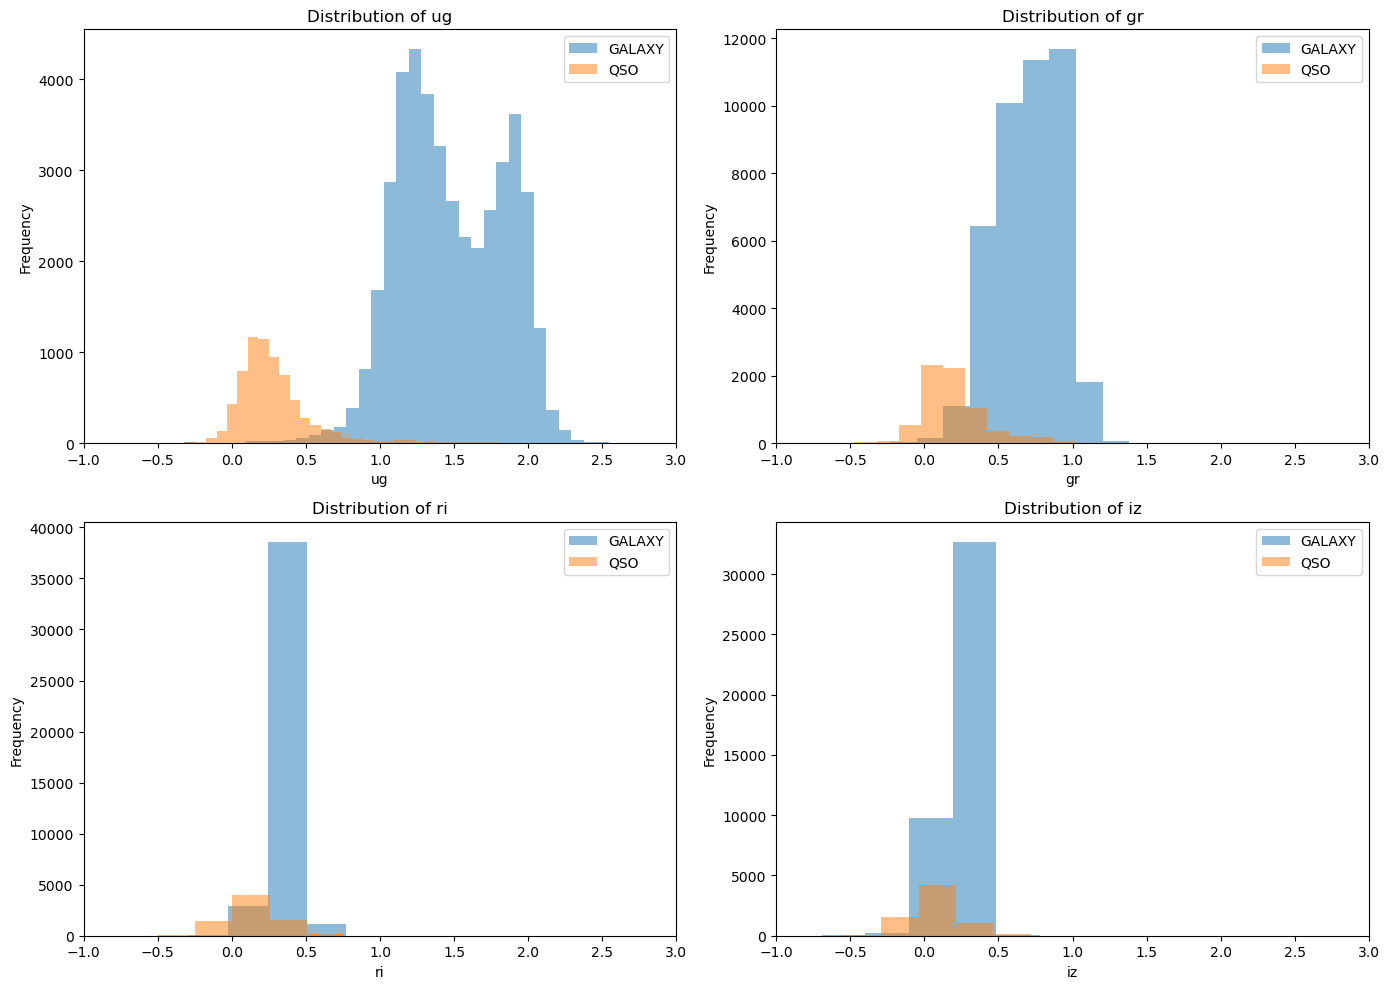

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, feature in enumerate(features):
    ax = axs[i // 2, i % 2]
    ax.hist(galaxy[feature], bins=80, alpha=0.5, label='GALAXY')
    ax.hist(qso[feature], bins=80, alpha=0.5, label='QSO')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_xlim(-1,3)
    ax.legend()

plt.tight_layout()
plt.show()

***Multi-layer Perceptron classifier***

In [29]:
#Classify the dataset against the target label.
X = df[features].values
Y = df['class_label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 42)

clf = MLPClassifier(solver='adam', activation='relu', alpha=1e-3, hidden_layer_sizes=10,
                    learning_rate_init=0.001, random_state=1, max_iter=500)
#with 5 hidden layers accuracy was 0.9843 compared to the 0.9862 of 100 layers... not worthy in terms of time

ind= np.random.choice(len(y_train), size=10000)
clf.fit(x_train[ind], y_train[ind])
y_pred = clf.predict(x_test)

Accuracy: 0.9844666666666667


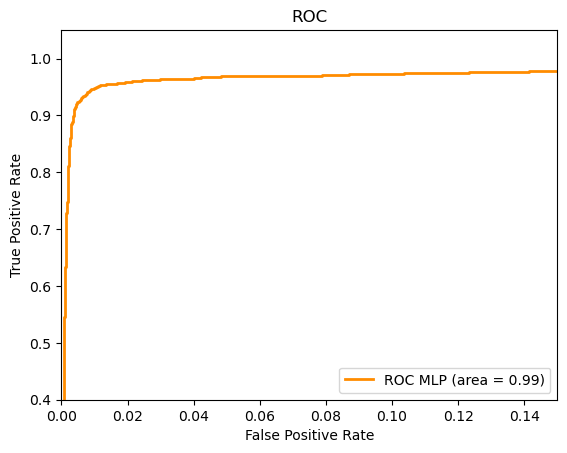

In [30]:
#ACCURACY
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

#ROC
y_pred_proba = clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC MLP (area = {auc:.2f})')

plt.xlim([0.0, 0.15])
plt.ylim([0.4, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [64]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

In [65]:
def build_model(hidden_layer_sizes, learning_rate, activation):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(4,)))
    
    for size in hidden_layer_sizes:
        model.add(keras.layers.Dense(units=size, activation=activation)) #fully connected layers
        
    model.add(keras.layers.Dense(1, activation='sigmoid')) # value 1 to have one label as output
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[f1_score]) #better to use this instead of accuracy because of inbalanced dataset
    return model


In [66]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [67]:
model= build_model([100, 50], 0.001, 'relu') # optimized by Tensorboard
model.fit(x=x_train, 
          y=y_train, 
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])


Epoch 1/10
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0958 - f1_score: 0.9119 - val_loss: 0.0762 - val_f1_score: 0.9279
Epoch 2/10
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0669 - f1_score: 0.9243 - val_loss: 0.0708 - val_f1_score: 0.9163
Epoch 3/10
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0637 - f1_score: 0.9320 - val_loss: 0.0609 - val_f1_score: 0.9281
Epoch 4/10
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0590 - f1_score: 0.9327 - val_loss: 0.0629 - val_f1_score: 0.9281
Epoch 5/10
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0573 - f1_score: 0.9327 - val_loss: 0.0589 - val_f1_score: 0.9285
Epoch 6/10
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0549 - f1_score: 0.9317 - val_loss: 0.0555 - val_f1_score: 0.9308
Epoch 7/10
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0539 - f1_score: 0.9298 - val_loss: 0.0544 - val_f1_score:

The code below takes the predicted probabilities from the model and applies a threshold of 0.5 to convert these probabilities into binary class labels (0 or 1).

In [68]:
y_pred= model.predict(x_test)
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

469/469 [==============================] - 0s 736us/step


<Axes: >

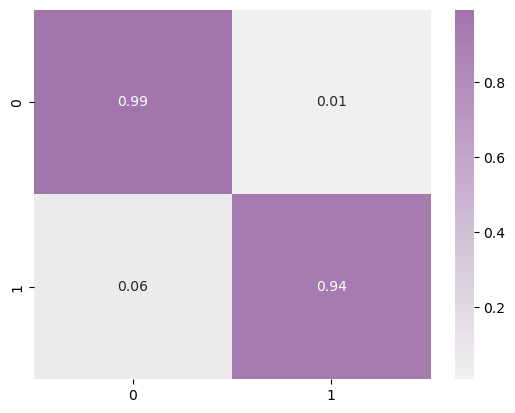

In [69]:
sns.heatmap(cm, annot=True, fmt='.2f', cmap=sns.light_palette('#a275ac', as_cmap=True))

In [13]:
%load_ext tensorboard

In [ ]:
#%tensorboard --logdir logs/fit

In [58]:
%tensorboard --logdir=logs/fit --host localhost --port 8893

This problem does not need a deep learning approach, indeed using KNN and GMM in the previous exercise I have reach very good values of f1-score and accuracy ($\sim$ 0.98-0.99) with a relative short time for computation. Here the algorithm architecture is more complex and heavy, it's also more difficult to optimize parameters (cross validation takes an eternity of time) and using Tensorboard means making a lot of trials, in general it's more complicated to get the best optimization of parameters. Anyway I manage to reach a f1-score of 0.9343, with 2 hidden layers of 100 and 50 neurons, a learning rate of 0.001 and a ReLu activation function.